# FastRCNN Object Proposal Investigation

In this notebook, we explore the built in region proposal network in VGGnet and Fast RCNN.

In [17]:
# Setup our notebook environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

from IPython.display import HTML

## Fast RCNN 

We will see object detections given by Fast RCNN.

In [2]:
# Common Python Library
lib_directory = "/raid/baldwin/code/people-tracking/lib"

# Models Directory
model_directory = "/raid/baldwin/code/people-tracking/models/"

import sys

# Current Path Information
previous_path_length = len(sys.path)

sys.path.insert(0, lib_directory)
sys.path.insert(0, model_directory)

# New Path Information
new_path_length = len(sys.path)

print("Path length: {}->{}".format(previous_path_length, new_path_length))

Path length: 10->12


In [3]:
from common.abstract.data import Image, Color
from human.classifier import HumanPresenceClassifier, CLASSES

HumanPresenceClassifier.saver_state_file = "/raid/baldwin/code/people-tracking/models/human/VGGnet_fast_rcnn_iter_150000.ckpt"

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

classifier = HumanPresenceClassifier()

person_class_index = CLASSES.index('person')

Tensor("Placeholder:0", shape=(?, ?, ?, 3), dtype=float32)
Tensor("conv5_3/Relu:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_conv/3x3/Relu:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rpn_cls_score/BiasAdd:0", shape=(?, ?, ?, 18), dtype=float32)
Tensor("rpn_cls_prob:0", shape=(?, ?, ?, ?), dtype=float32)
Tensor("Reshape_2:0", shape=(?, ?, ?, 18), dtype=float32)
Tensor("rpn_bbox_pred/BiasAdd:0", shape=(?, ?, ?, 36), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 3), dtype=float32)
Tensor("conv5_3/Relu:0", shape=(?, ?, ?, 512), dtype=float32)
Tensor("rois:0", shape=(?, 5), dtype=float32)
[<tf.Tensor 'conv5_3/Relu:0' shape=(?, ?, ?, 512) dtype=float32>, <tf.Tensor 'rois:0' shape=(?, 5) dtype=float32>]
Tensor("fc7/fc7:0", shape=(?, 4096), dtype=float32)
INFO:tensorflow:Restoring parameters from /raid/baldwin/code/people-tracking/models/human/VGGnet_fast_rcnn_iter_150000.ckpt


In [4]:
# Helpful utilities

from common.utils.image_manipulation import draw_spatial_results_on_image

def annotate_image(image, classifications, only_persons=False):
    if only_persons:
        spatial_results = classifications.get('person', list())
        image = draw_spatial_results_on_image(image, spatial_results=spatial_results)
        return image
    
    for class_label in classifications.keys():
        spatial_results = classifications.get(class_label, list())
        image = draw_spatial_results_on_image(image, spatial_results=spatial_results)
    return image

def classify_and_annotate_image(image, only_persons=True):
    image_classifications = classifier.classify(image)
    return annotate_image(image, image_classifications, only_persons)

def show_image(image, plot_title=''):
    plt.figure()
    plt.title(plot_title)
    plt.imshow(image.get_np_array())

In [5]:
image_path = 'samples/hugging.jpg'

Image width 640 height 426
Person count: 1


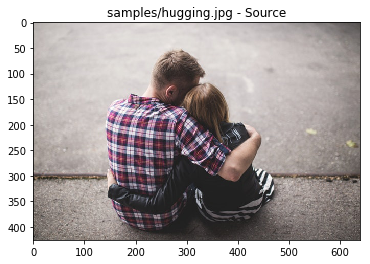

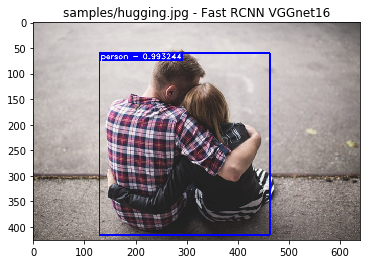

In [6]:
image = Image.from_file(image_path)
print "Image width {} height {}".format(image.width(), image.height())

show_image(image, '{} - Source'.format(image_path))

classifications = classifier.classify(image)
show_image(annotate_image(image, classifications, only_persons=True), '{} - Fast RCNN VGGnet16'.format(image_path))
print "Person count: {}".format(len(classifications.get('person')))

In [7]:
# Let's extract the data before post-processing
def get_person_boxes_and_scores(image):
    object_proposals = classifier.detect_object_proposals(image.cv2_encode())
    boxes = object_proposals.get_boxes_for_class_index(person_class_index)
    scores = object_proposals.get_scores_for_class_index(person_class_index)
    return boxes, scores

boxes, scores = get_person_boxes_and_scores(image)
print "Boxes: {}, Scores: {}".format(boxes.shape, scores.shape)

flattened_vector = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32)

print "Flattened: {}".format(flattened_vector.shape)

def threshold_proposals(flattened, threshold=0.85):
    indices_above_threshold = np.where(flattened[:, -1] >= threshold)[0]
    reduced_proposals = flattened_vector[indices_above_threshold]
    return reduced_proposals

Boxes: (193, 4), Scores: (193,)
Flattened: (193, 5)


In [8]:
from common.abstract.machine_learning.result.objects import SpatialResult

from common.utils.data_manipulation import parse_bounding_box
from common.abstract.cartesian import Coordinate
from common.abstract.shapes import Rectangle

# Let's draw all of these proposals
def proposals_to_spatial_results(proposals, label='person'):
    results = list()
    for proposal in proposals:
        x_top, y_top, x_bottom, y_bottom = proposal[:4]
        score = proposal[-1]
        
        x_top, y_top, width, height = parse_bounding_box(x_top, y_top, x_bottom, y_bottom)
        shape = Rectangle(width=width, height=height)
        origin = Coordinate(x_top, y_top)
        spatial_result = SpatialResult(label=label, score=score, shape=shape, origin=origin)
        
        results.append(spatial_result)
    return results

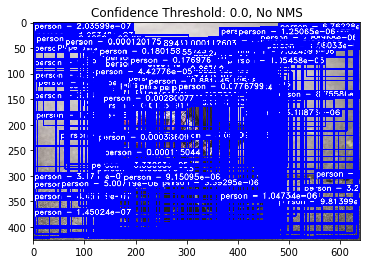

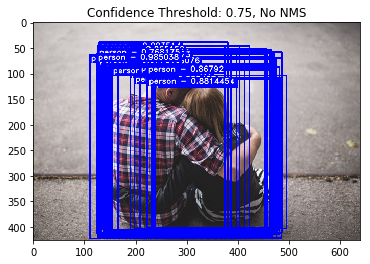

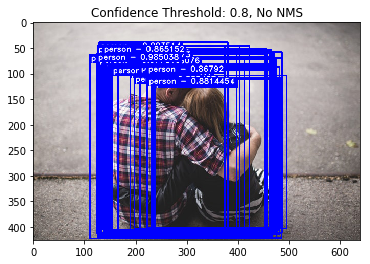

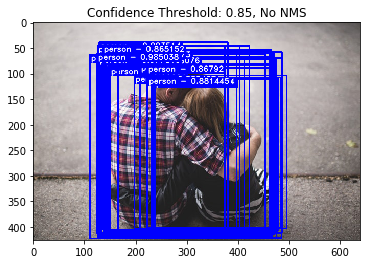

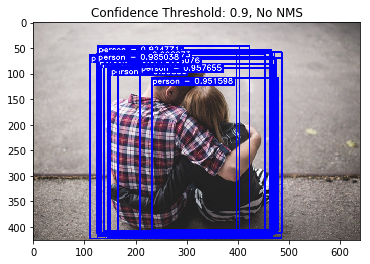

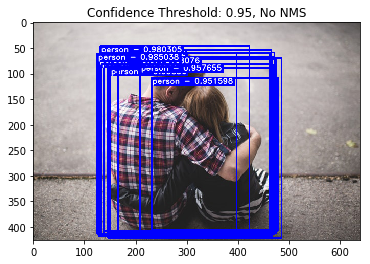

In [9]:
for threshold in [0.00, 0.75, 0.80, 0.85, 0.90, 0.95]:
    proposals = threshold_proposals(flattened_vector, threshold=threshold)
    spatial_results = proposals_to_spatial_results(proposals)
    show_image(draw_spatial_results_on_image(image, spatial_results=spatial_results), 'Confidence Threshold: {}, No NMS'.format(threshold))

## Similarity Graph

We want to create an undirected graph between each region proposal. 

There will be weights assigned to each edge that represents the similarity index between two nodes (images).

We will add denote our nodes on our graph by using (x1,y1) (x2,y2) as their index.

In [81]:
def color_hist(image, region):
    chans = cv2.split(image.get_np_array())
    colors = ("b", "g", "r")
    
    show_image(image, region)
    plt.figure()
    plt.title("'Flattened' Color Histogram")
    plt.xlabel("Bins")
    plt.ylabel("# of Pixels")
    features = []

    # loop over the image channels
    for (chan, color) in zip(chans, colors):
        # create a histogram for the current channel and
        # concatenate the resulting histograms for each
        # channel
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        features.extend(hist)

        # plot the histogram
        plt.plot(hist, color = color)
        plt.xlim([0, 256])
        
def color_histogram(image):
    chans = cv2.split(image.get_np_array())
    colors = ("b", "g", "r")
    histogram = list()

    # loop over the image channels
    for chan in chans:
        # create a histogram for the current channel and
        # concatenate the resulting histograms for each
        # channel
        histogram.append(cv2.calcHist([chan], [0], None, [256], [0, 256]))
    return histogram

[ 157476.14059803  252549.65942406  218317.58841777]
[  9844.48345201  13243.58635847  11689.97005333]
[ 134.51148378  144.01210006  138.25387016]
[ 159818.04442074  229954.34563961  200593.58552729]
[ 131597.82098259  189067.59262973  164701.43692902]
[ 125690.22034059  171902.36815751  148092.57928356]
[ 148066.4808695   203513.09022503  172046.7178917 ]
[  97028.19147244  129621.43819279  116379.47426543]
[ 37555.83387046  47028.66717989  42994.62679403]
[ 162382.01099937  225032.88088227  197011.76694078]
[ 186129.24688879  288793.87390403  249312.3116582 ]
[  92722.24297386  143942.28769991  122373.15644043]
[ 138808.84340541  195956.36997232  171281.24306261]
[  99736.97805262  132476.66642496  116952.38622305]
[ 61559.14164879  85246.54563521  77339.98740789]
[ 149562.48870956  209429.25859676  179538.42268119]
[ 22070.40347691  23024.07699331  21261.97918598]
[ 12653.40198547  13666.1133939   12192.46822949]
[ 21766.24331374  23024.54589101  20861.00869401]
[ 5154.2300997   629

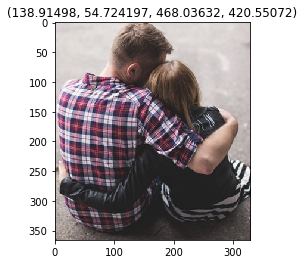

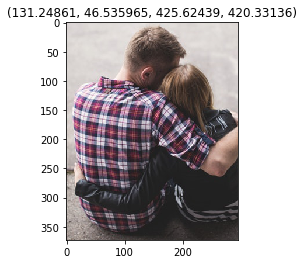

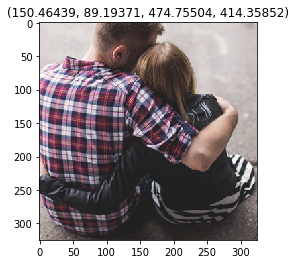

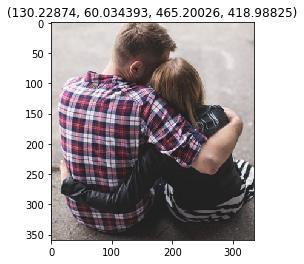

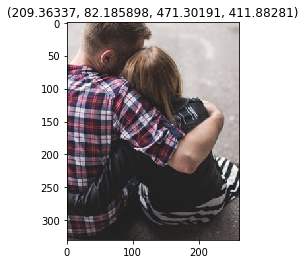

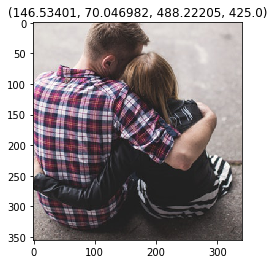

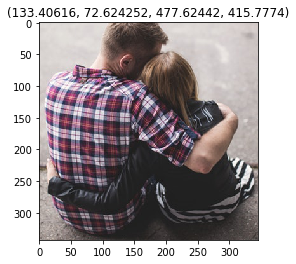

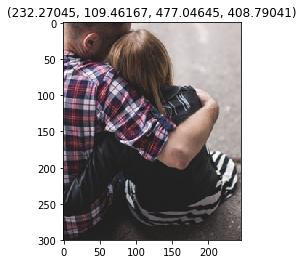

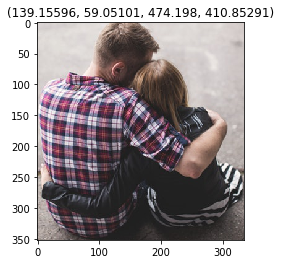

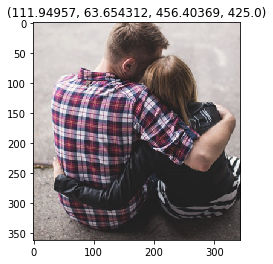

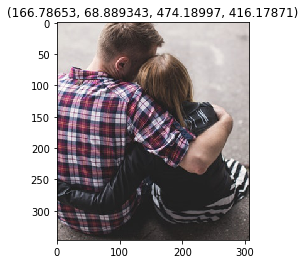

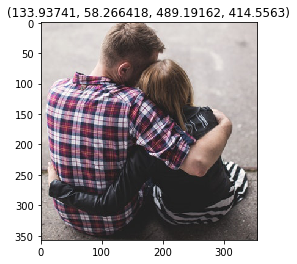

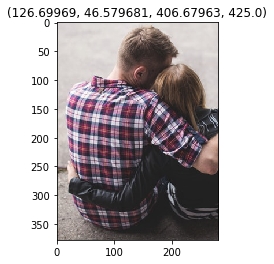

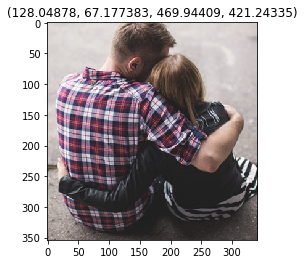

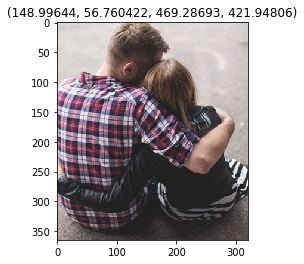

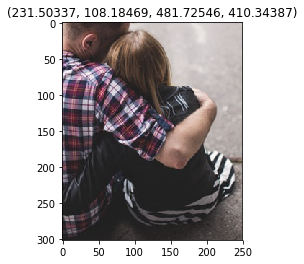

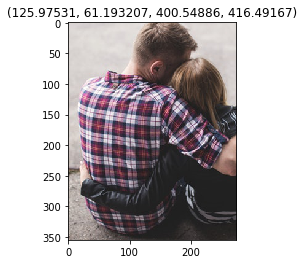

In [86]:
threshold = 0.9

proposals = threshold_proposals(flattened_vector, threshold=threshold)

from collections import namedtuple
from scipy.spatial import distance as dist

Similarity = namedtuple('Similarity', ['color'])

G = dict()

class Region(object):
    
    def __init__(self, position, image):
        self.position = position
        self.image = image
        self.histogram = color_histogram(image)
        self.group = None
        self.edges = dict()
        
    def __repr__(self):
        return "R({})".format(self.position)
    
    def generate_edge(self, other_region):
        self.edges[other_region] = similarity(self, other_region)

def similarity(r1, r2):
    if r1 == r2:
        return None
    color = np.array([])
    # for each color channel
    for i in range(3):
        color = np.append(color, cv2.compareHist(r1.histogram[i], r2.histogram[i], cv2.HISTCMP_CHISQR))
    print(color)
    return Similarity(color=color)
    
for proposal in proposals:
    region = tuple(proposal[:4])
    cropped_image = image.crop(*region)
    show_image(cropped_image, region)
    G[region] = Region(region, cropped_image)
    
    # histogram
    #color_hist(cropped_image, region)
    
# Generate Edges
regions = G.values()
for r1 in regions:
    for r2 in regions:
        r1.generate_edge(r2)
        
for r in regions:
    print "Region {} Edges: {}".format(r, len(r.edges))